# [Data Cleaning] Scalable Unsupervised Machine Learning Approaches for Discovering Latent Customer Segments in Online Retail Data

- Author: Joleil Villena (joleilvillena.tech@gmail.com)
- Organization: Asian Institute Management
- Purpose: Capstone Project for Postgraduate Diploma in Artificial Intelligence and Machine Learning - Data Cleaning for EDA and Model Development

<b>Data Set</b>
| Information             | Details |
|-------------------------|---------|
| Name                    | Online Retail |
| Creation Date           | Donated on 11/5/2015 |
| Source                  | UC Irvine Machine Learning Repository |
| Link                    | https://archive.ics.uci.edu/dataset/352/online+retail |
| Description             | Transactional data set containing all transactions between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail company |
| Data Set Characteristics| Multivariate, Sequential, Time-Series |
| Subject Area            | Business |
| Associated Tasks        | Classification, Clustering |
| Feature Type            | Integer, Real |
| Instances               | 541,909 |
| Features                | 6 |
| Additional Information  | The company mainly sells unique all-occasion gifts. Many customers are wholesalers. |


# Data Cleaning

## Import Libraries

In [ ]:
# Import libraries
import numpy as np
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from collections import defaultdict
from IPython.display import display

%matplotlib inline

import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

## Read Data
| Variable Name | Role     | Type        | Description                                                                                     | Units    | Missing Values |
|---------------|---------|------------|-------------------------------------------------------------------------------------------------|---------|----------------|
| InvoiceNo     | ID      | Categorical | A 6-digit integral number uniquely assigned to each transaction. If this code starts with 'C', it indicates a cancellation |         | no             |
| StockCode     | ID      | Categorical | A 5-digit integral number uniquely assigned to each distinct product                             |         | no             |
| Description   | Feature | Categorical | Product name                                                                                     |         | no             |
| Quantity      | Feature | Integer     | The quantities of each product (item) per transaction                                            |         | no             |
| InvoiceDate   | Feature | Date        | The day and time when each transaction was generated                                             |         | no             |
| UnitPrice     | Feature | Continuous  | Product price per unit                                                                           | GBP | no             |
| CustomerID    | Feature | Categorical | A 5-digit integral number uniquely assigned to each customer                                     |         | no             |
| Country       | Feature | Categorical | The name of the country where each customer resides                                              |         | no             |

Source: UC Irvine Machine Learning Repository https://archive.ics.uci.edu/dataset/352/online+retail 


In [2]:
# Read and view data set
data = pd.read_excel("../data/Online Retail.xlsx")

## Initial Checks on Data

In [3]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [5]:
# Initial Check 

def str_py(df, pred=None):
    # Put stats into a dictionary
    # Align to the same index (using original df columns)
    data_summary = {
        'types': df.dtypes,
        'counts': df.count(),
        'distincts': df.nunique(),
        'nulls': df.isnull().sum(),
        'missing ratio': (df.isnull().sum() / len(df)) * 100,
        'uniques': df.apply(lambda x: x.unique()),
        'skewness': df.skew(numeric_only=True),
        'kurtosis': df.kurt(numeric_only=True)
    }

    # Add Correlation if pred is provided
    if pred is not None:
        # Note: Use numeric_only=True to prevent errors with correlations
        corr_series = df.corr(numeric_only=True)[pred]
        data_summary[f'corr {pred}'] = corr_series

    # Create the DataFrame from the dictionary
    res_df = pd.DataFrame(data_summary)

    # 4. Final output tasks
    print('Data Shape:', df.shape)
    print('==============================')
    print('Data Types: ')
    print(res_df['types'].value_counts())
    print('==============================')
    
    return res_df

# Run:
details = str_py(data)

# Apply formatting: 
# - {:,} adds the thousands separator
# - {:.2f} limits decimals to 2 places (adjust as needed)

# display(details.sort_values(by='missing ratio', ascending=False).style.format({
#     'counts': '{:,.0f}',
#     'distincts': '{:,.0f}',
#     'nulls': '{:,.0f}',
#     'missing ratio': '{:.2f}%',
#     'skewness': '{:.2f}',
#     'kurtosis': '{:.2f}'
# }))

col_index = details.columns.get_loc('uniques')
styled_details = (
    details.sort_values(by='missing ratio', ascending=False)
    .style
    .format({
        'counts': '{:,.0f}',
        'distincts': '{:,.0f}',
        'nulls': '{:,.0f}',
        'missing ratio': '{:.2f}%'
    })
    # Align cell values in 'uniques' column
    .set_properties(subset=['uniques'], **{'text-align': 'left'})
    # Align column header for 'uniques'
    .set_table_styles([
        {'selector': f'th.col{col_index}', 'props': [('text-align', 'left')]}
    ], overwrite=False)
)
styled_details

Data Shape: (541909, 8)
Data Types: 
types
object            4
float64           2
datetime64[ns]    1
int64             1
Name: count, dtype: int64


## Rename Columns

In [6]:
# Rename columns
df = data.copy()
df.rename(columns={
    'InvoiceNo':'invoice_number'
    , 'StockCode':'stock_code'
    , 'Description':'description'
    , 'Quantity':'quantity'
    , 'InvoiceDate':'invoice_date'
    , 'UnitPrice':'unit_price'
    , 'CustomerID':'customer_id'
    , 'Country':'country'
}, inplace=True)

df

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


## Check Data Types

In [7]:
# Check data types
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   invoice_number  541909 non-null  object        
 1   stock_code      541909 non-null  object        
 2   description     540455 non-null  object        
 3   quantity        541909 non-null  int64         
 4   invoice_date    541909 non-null  datetime64[ns]
 5   unit_price      541909 non-null  float64       
 6   customer_id     406829 non-null  float64       
 7   country         541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Fix DateTime Data Type

In [8]:
# Fix datetime data type
df["invoice_date"] = pd.to_datetime(df["invoice_date"])
df

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [9]:
df.invoice_date.isna().sum()

np.int64(0)

In [10]:
dates = df["invoice_date"].agg(["min", "max"])
dates["days_in_between"] = dates["max"] - dates["min"]
dates

min                2010-12-01 08:26:00
max                2011-12-09 12:50:00
days_in_between      373 days 04:24:00
Name: invoice_date, dtype: object

## Check Unique Values

In [11]:
# Check Unique Values
print('Distinct/unique values per column: ')
df.nunique()


Distinct/unique values per column: 


invoice_number    25900
stock_code         4070
description        4223
quantity            722
invoice_date      23260
unit_price         1630
customer_id        4372
country              38
dtype: int64

In [12]:
# Country is expected to be mostly the United Kingdom
print(f'Top 20 countries out of {df.country.nunique()} countries: ')
print('(Based on number of instances or transactions in the data)')
df.country.value_counts().head(20)

Top 20 countries out of 38 countries: 
(Based on number of instances or transactions in the data)


country
United Kingdom     495478
Germany              9495
France               8557
EIRE                 8196
Spain                2533
Netherlands          2371
Belgium              2069
Switzerland          2002
Portugal             1519
Australia            1259
Norway               1086
Italy                 803
Channel Islands       758
Finland               695
Cyprus                622
Sweden                462
Unspecified           446
Austria               401
Denmark               389
Japan                 358
Name: count, dtype: int64

In [13]:
# sorted(df["country"].unique().tolist())
print(f'Country names present in the data: \n\n{df.country.unique()}')

Country names present in the data: 

['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


In [14]:
# Transactions with unspecified country
num_transactions_unspecified = len(df[df.country == 'Unspecified'])

# Unique customers with unspecified country
num_customers_unspecified = df[df.country == 'Unspecified']['customer_id'].nunique()

# Transactions with unspecified country AND null customer_id
num_null_customer_unspecified = len(df[(df.country == 'Unspecified') & (df.customer_id.isna())])

print(f"Number of transactions with unspecified values in the Country column: {num_transactions_unspecified:,}")
print(f"Number of unique customers with unspecified values in the Country column: {num_customers_unspecified:,}")
print(f"Number of transactions with unspecified Country AND null customer_id: {num_null_customer_unspecified:,}")

Number of transactions with unspecified values in the Country column: 446
Number of unique customers with unspecified values in the Country column: 4
Number of transactions with unspecified Country AND null customer_id: 202


### Reformat Country column

In [15]:
print('Country items to change: ')
df["country"].value_counts().loc[["EIRE", "RSA"]]

Country items to change: 


country
EIRE    8196
RSA       58
Name: count, dtype: int64

In [16]:
# Correct Country Names
## EIRE -> Ireland
## RSA -> South Africa

df["country"] = df["country"].replace({
    "EIRE": "Ireland",
    "RSA": "South Africa"
})

print('Country items corrected: ')
df["country"].value_counts().loc[["Ireland", "South Africa"]]

Country items corrected: 


country
Ireland         8196
South Africa      58
Name: count, dtype: int64

In [17]:
# sorted(df["country"].unique().tolist())
print(f'Country names present in the data: \n\n{df.country.unique()}')

Country names present in the data: 

['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'Ireland' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'South Africa']


## Handle Missing Values and Null Values

In [18]:
# Handle Missing Values and Null Values

# -------------------------------
# Total number of rows
total_rows = len(df)
total_rows_fmt = f"{total_rows:,}"

# -------------------------------
# Masks
empty_mask = df.eq('')
blank_mask = df.apply(lambda x: x.astype(str).str.match(r'^\s+$'))
null_mask = df.isna()

# -------------------------------
# Counts per column
empty_vals = empty_mask.sum()
blank_vals = blank_mask.sum()
null_vals = null_mask.sum()

# TOTAL per column = rows with ANY issue
total_issue_vals = (empty_mask | blank_mask | null_mask).sum()

# -------------------------------
# Build summary DataFrame
missing_summary = pd.DataFrame({
    'Empty Strings': empty_vals,
    'Blank / Spaces only': blank_vals,
    'Null Values': null_vals,
    'Total (per column)': total_issue_vals
})

# Column-wise TOTAL row
missing_summary.loc['Total (per category)'] = missing_summary.sum(axis=0)

# -------------------------------
# Percentages (ALL out of total rows of the DataFrame)
percent = (missing_summary / total_rows * 100).round(2)

# -------------------------------
# Formatting
def format_cell(count, pct):
    if count == 0:
        return 0
    return f"{count:,} ({pct}%)"

missing_summary_df = pd.DataFrame({
    col: [
        format_cell(missing_summary.loc[row, col], percent.loc[row, col])
        for row in missing_summary.index
    ]
    for col in missing_summary.columns
}, index=missing_summary.index)

# -------------------------------
# Output
print(f"Total rows in dataset: {total_rows_fmt}\n")
print("Missing / Blank / Null Values per Column (Count + % of total rows):")
missing_summary_df


Total rows in dataset: 541,909

Missing / Blank / Null Values per Column (Count + % of total rows):


,Empty Strings,Blank / Spaces only,Null Values,Total (per column)
invoice_number,0,0,0,0
stock_code,0,0,0,0
description,0,0,"1,454 (0.27%)","1,454 (0.27%)"
quantity,0,0,0,0
invoice_date,0,0,0,0
unit_price,0,0,0,0
customer_id,0,0,"135,080 (24.93%)","135,080 (24.93%)"
country,0,0,0,0
Total (per category),0,0,"136,534 (25.2%)","136,534 (25.2%)"


### Handle Null Values in 'customer_id' column

In [19]:
NULLS_CUSTID = df[df["customer_id"].isna()].shape[0]
print(f'Number of entries with null customer_id: {NULLS_CUSTID}')
df[df["customer_id"].isna()]

Number of entries with null customer_id: 135080


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [20]:
cols = [
    "invoice_number",
    "stock_code",
    "description",
    "quantity",
    "invoice_date",
    "unit_price",
    "country"
]

print('Nulls in the customer_id correspond affect the following: ')
df.loc[df["customer_id"].isna(), cols].nunique() \
    .sort_values(ascending=False) \
    .rename("count").reset_index() \
    .rename(columns={"index": "transaction detail"})

Nulls in the customer_id correspond affect the following: 


,transaction detail,count
0,stock_code,3810
1,invoice_number,3710
2,description,3554
3,invoice_date,3161
4,unit_price,1195
5,quantity,541
6,country,9


In [21]:
# Remove Entries with Null 'customer_id'
df = df.dropna(subset=['customer_id'])

print(f'Correct no. of entries dropped successfully? {(data.shape[0] - NULLS_CUSTID)==df.shape[0]}')
df

Correct no. of entries dropped successfully? True


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


### Handle Null Values and Excess Entries in 'description' column

In [22]:
print(f'Remaining null values in description after dropping null customer_id: {df["description"].isna().sum()}')

df[df["description"].isna()]

# cols = [
#     "invoice_number",
#     "stock_code",
#     "quantity",
#     "invoice_date",
#     "unit_price",
#     "customer_id",
#     "country"
# ]

# df.loc[df["description"].isna(), cols].nunique()

Remaining null values in description after dropping null customer_id: 0


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [23]:
print(f'Excess count of descriptions vs. stock_code: {df['description'].nunique() - df['stock_code'].nunique()}\n')

print('Count of stok_code vs. count of descriptions: ')
df[['stock_code', 'description']].nunique()

Excess count of descriptions vs. stock_code: 212

Count of stok_code vs. count of descriptions: 


stock_code     3684
description    3896
dtype: int64

In [24]:
# Count unique descriptions per 'stock_code'
desc_counts = df.groupby('stock_code')['description'].nunique().reset_index()

# Rename the count column for clarity
desc_counts.rename(columns={'description': 'NumDescriptions'}, inplace=True)

# Sort first by number of descriptions descending, then by 'stock_code' ascending
desc_counts_sorted = desc_counts.sort_values(
    by=['NumDescriptions', 'stock_code'],
    ascending=[False, True]
)

print('Show stock_code with multiple descriptions: ')
desc_counts_sorted[desc_counts_sorted.NumDescriptions>1]

Show stock_code with multiple descriptions: 


,stock_code,NumDescriptions
1960,23196,4
2000,23236,4
1559,22776,3
1713,22937,3
1891,23126,3
...,...,...
3410,85184C,2
3411,85185B,2
3455,90014A,2
3456,90014B,2


In [25]:
print('Sample stock_id with multiple descriptions: ')
df.loc[df['stock_code'].isin(desc_counts_sorted['stock_code'].head(5))] \
    .groupby('stock_code')['description'].value_counts() \
    # .rename('count') \
    # .reset_index() \
    # .sort_values(['stock_code', 'count'], ascending=[True, False])

Sample stock_id with multiple descriptions: 


stock_code  description                       
22776       SWEETHEART CAKESTAND 3 TIER           356
            SWEETHEART 3 TIER CAKE STAND          134
            CAKESTAND, 3 TIER, LOVEHEART            1
22937       BAKING MOULD CHOCOLATE CUPCAKES       140
            BAKING MOULD CHOCOLATE CUP CAKES        2
            BAKING MOULD CUPCAKE CHOCOLATE          1
23126       FELTCRAFT GIRL AMELIE KIT             268
            DOLLCRAFT GIRL AMELIE                   8
            DOLLCRAFT GIRL AMELIE KIT               8
23196       VINTAGE LEAF MAGNETIC NOTEPAD         221
            RETRO LEAVES MAGNETIC NOTEPAD          20
            RETO LEAVES MAGNETIC SHOPPING LIST      3
            LEAVES MAGNETIC  SHOPPING LIST          2
23236       STORAGE TIN VINTAGE DOILY             181
            DOILEY STORAGE TIN                    118
            DOILEY BISCUIT TIN                     13
            STORAGE TIN VINTAGE DOILEY              1
Name: count, dtype: int64

### Standardize Descriptions

In [26]:
# Check descriptions: ALL CAPS vs NOT ALL CAPS

print('Checking capitalization of descriptions...\n')

# Boolean masks
all_caps_mask = df['description'].str.isupper()
not_all_caps_mask = ~all_caps_mask

# Total number of descriptions
total_descriptions = len(df)

# Counts and percentages
num_all_caps = all_caps_mask.sum()
num_not_all_caps = not_all_caps_mask.sum()

print(f'ALL CAPS descriptions: {num_all_caps:,} / {total_descriptions:,} '
      f'({num_all_caps/total_descriptions:.2%})')

print(f'/NOT/ ALL CAPS descriptions: {num_not_all_caps:,} / {total_descriptions:,} '
      f'({num_not_all_caps/total_descriptions:.2%})\n')

# Show samples
# print('Sample of ALL CAPS descriptions:')
# display(df.loc[all_caps_mask, ['stock_code', 'description']].head(10))

print('Sample of descriptions that are /NOT/ ALL CAPS:')
display(df.loc[not_all_caps_mask, ['stock_code', 'description']])

Checking capitalization of descriptions...

ALL CAPS descriptions: 404,875 / 406,829 (99.52%)
/NOT/ ALL CAPS descriptions: 1,954 / 406,829 (0.48%)

Sample of descriptions that are /NOT/ ALL CAPS:


,stock_code,description
141,D,Discount
482,21705,BAG 500g SWIRLY MARBLES
918,46000M,POLYESTER FILLER PAD 45x45cm
2038,46000R,POLYESTER FILLER PAD 45x30cm
2039,46000S,POLYESTER FILLER PAD 40x40cm
...,...,...
540158,21704,BAG 250g SWIRLY MARBLES
540281,21705,BAG 500g SWIRLY MARBLES
541541,M,Manual
541612,21705,BAG 500g SWIRLY MARBLES


In [27]:
# Standardize Descriptions
print('Standardizing Descriptions...\n')
df["description"] = df.groupby("stock_code")["description"] \
                        .transform(lambda x: x.mode().iloc[0])

print('Check the same set of sample of stock_code with multiple descriptions: ')
df.loc[df['stock_code'].isin(desc_counts_sorted['stock_code'].head(5))] \
    .groupby('stock_code')['description'].value_counts()

Standardizing Descriptions...

Check the same set of sample of stock_code with multiple descriptions: 


stock_code  description                    
22776       SWEETHEART CAKESTAND 3 TIER        491
22937       BAKING MOULD CHOCOLATE CUPCAKES    143
23126       FELTCRAFT GIRL AMELIE KIT          284
23196       VINTAGE LEAF MAGNETIC NOTEPAD      246
23236       STORAGE TIN VINTAGE DOILY          313
Name: count, dtype: int64

In [28]:
# Verify standardization for all stock codes with multiple descriptions
print('Standardized descriptions for all stock_code:')

df.groupby('stock_code')['description'].value_counts().sort_index(level='stock_code', ascending=False)

Standardized descriptions for all stock_code:


stock_code  description                 
POST        POSTAGE                         1196
PADS        PADS TO MATCH ALL CUSHIONS         4
M           Manual                           465
DOT         DOTCOM POSTAGE                    16
D           Discount                          77
                                            ... 
10133       COLOURING PENCILS BROWN TUBE     125
10125       MINI FUNKY DESIGN TAPES           64
10120       DOGGY RUBBER                      30
10080       GROOVY CACTUS INFLATABLE          21
10002       INFLATABLE POLITICAL GLOBE        49
Name: count, Length: 3684, dtype: int64

## Handle Invalid Values

In [29]:
# Check descriptive statistics of numeric columns
print('Dropping the null customer_id entries have eliminated the negative unit_price entries. ')
print('\nNext Steps: ')
print('    1. Handle zeroes in unit_price column.')
print('    2. Handle negative values and zeroes in the quantity column.')
df[['quantity', 'unit_price', 'invoice_date']].describe()

Dropping the null customer_id entries have eliminated the negative unit_price entries. 

Next Steps: 
    1. Handle zeroes in unit_price column.
    2. Handle negative values and zeroes in the quantity column.


,quantity,unit_price,invoice_date
count,406829.000000,406829.000000,406829
mean,12.061303,3.460471,2011-07-10 16:30:57.879207424
min,-80995.000000,0.000000,2010-12-01 08:26:00
25%,2.000000,1.250000,2011-04-06 15:02:00
50%,5.000000,1.950000,2011-07-31 11:48:00
75%,12.000000,3.750000,2011-10-20 13:06:00
max,80995.000000,38970.000000,2011-12-09 12:50:00
std,248.693370,69.315162,NaN


Notice potential invalid transactions and outliers...


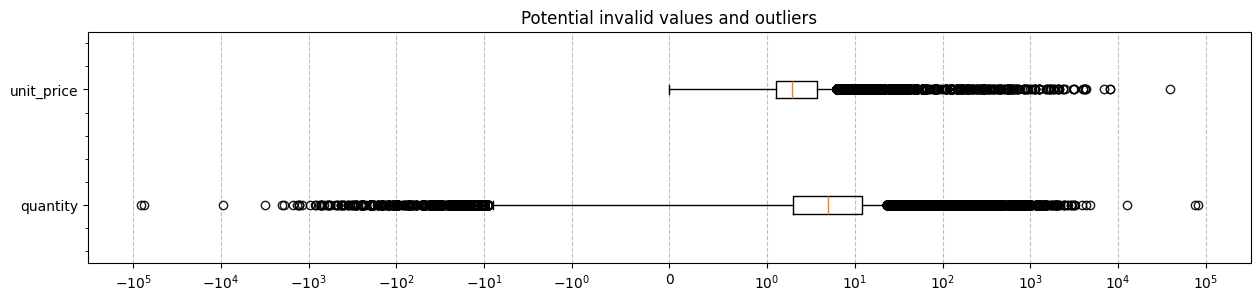

In [30]:
# Boxplots of numeric columns
fig, ax = plt.subplots(figsize=(15, 3))

flierprops = dict(
    marker='o',
    markersize=6,
    linestyle='none',
    alpha=0.9
)

ax.boxplot(
    df[['quantity', 'unit_price']],
    vert=False,
    whis=1.0,              # tighter whiskers → more visible outliers
    flierprops=flierprops
)

ax.set_yticklabels(['quantity', 'unit_price'])

# Grid styling
ax.grid(False, axis='y')
ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.8)
ax.grid(True, axis='x', which='minor', linestyle='--', alpha=0.3)
ax.minorticks_on()

# Log scale to handle skew (safe for retail data)
ax.set_xscale('symlog', linthresh=1)

ax.set_title("Potential invalid values and outliers")
ax.set_ylabel("")
ax.set_xlabel("")

print('Notice potential invalid transactions and outliers...')
plt.show()

### Handle Invalid unit_price

In [31]:
# Check Invalid unit_price
conditions = {
    "Invoices with < 0 unit_price": df["unit_price"] < 0,
    "Invoices with > 0 AND < 0.01 unit_price": (df["unit_price"] > 0) & (df["unit_price"] < 0.01),
    "Invoices with 0 unit_price": df["unit_price"] == 0
}

# -------------------------------
# Summary counts
summary = {
    label: mask.sum()
    for label, mask in conditions.items()
}

print("Summary of unit_price anomalies")
print("-" * 40)
for label, count in summary.items():
    print(f"{label}: {count}")

print("\n" + "=" * 80 + "\n")

# -------------------------------
# Detailed output
for label, mask in conditions.items():
    subset = df.loc[mask]
    print(f"{label}: {subset.shape[0]}")
    display(subset)
    print("-" * 80)
print("=" * 80)

Summary of unit_price anomalies
----------------------------------------
Invoices with < 0 unit_price: 0
Invoices with > 0 AND < 0.01 unit_price: 4
Invoices with 0 unit_price: 40


Invoices with < 0 unit_price: 0


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


--------------------------------------------------------------------------------
Invoices with > 0 AND < 0.01 unit_price: 4


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,13952.0,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,15618.0,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 14:58:00,0.001,16198.0,United Kingdom
361741,568375,BANK CHARGES,Bank Charges,1,2011-09-26 17:01:00,0.001,13405.0,United Kingdom


--------------------------------------------------------------------------------
Invoices with 0 unit_price: 40


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,Ireland
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


--------------------------------------------------------------------------------


In [32]:
print('Dropping transactions with invalid unit_price...\n')

drop_mask = (
    (df["unit_price"] < 0) |
    ((df["unit_price"] > 0) & (df["unit_price"] < 0.01)) |
    (df["unit_price"] == 0)
)

# Cleaned DataFrame
df_valid = df.loc[~drop_mask].copy()

# --- calculate and check number of rows dropped ---
rows_dropped = df.shape[0] - df_valid.shape[0]
print(f"Number of rows dropped: {rows_dropped:,}")

invalid_unit_price = df.loc[drop_mask]
print(f"Correct number of rows dropped? {rows_dropped == invalid_unit_price.shape[0]}")

df_valid

Dropping transactions with invalid unit_price...

Number of rows dropped: 44
Correct number of rows dropped? True


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


### Handle Invalid quantity

In [33]:
# Check Invalid quantity
conditions_qty = {
    "Invoices with < 0 quantity": df_valid["quantity"] < 0,
    "Invoices with 0 quantity": df_valid["quantity"] == 0,
}

# -------------------------------
# Summary counts
summary_qty = {label: mask.sum() for label, mask in conditions_qty.items()}

print("Summary of quantity anomalies")
print("-" * 40)
for label, count in summary_qty.items():
    print(f"{label}: {count}")

print("\n" + "=" * 80 + "\n")

# -------------------------------
# Detailed output
for label, mask in conditions_qty.items():
    subset = df_valid.loc[mask]
    print(f"{label}: {subset.shape[0]}")
    display(subset)
    print("-" * 80)
print("=" * 80)

Summary of quantity anomalies
----------------------------------------
Invoices with < 0 quantity: 8905
Invoices with 0 quantity: 0


Invoices with < 0 quantity: 8905


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


--------------------------------------------------------------------------------
Invoices with 0 quantity: 0


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


--------------------------------------------------------------------------------


In [34]:
# Check format of invoice_number with quantity < 0
print('Checking the format of invoice_number with quantity < 0...\n')

# Filter invoices with negative quantity
neg_quantity_invoices = df_valid[df_valid['quantity'] < 0]

# Check which of these start with 'C'
start_with_C = neg_quantity_invoices['invoice_number'].str.startswith('C')

# Are all negative-quantity invoices starting with 'C'?
all_start_with_C = start_with_C.all()

print(f"Total invoices with quantity < 0: {neg_quantity_invoices.shape[0]:,}")
print(f"Total of those starting with 'C': {start_with_C.sum():,}")
print(f"All relevant invoices start with C? {all_start_with_C}")


Checking the format of invoice_number with quantity < 0...

Total invoices with quantity < 0: 8,905
Total of those starting with 'C': 8,905
All relevant invoices start with C? True


#### Route A: Net Quantity
##### Isolated Invoices (Negative quantity)

In [35]:
# Isolated invoices with negative quantity

# Filter negative quantity transactions
neg_transactions = df_valid[df_valid['quantity'] < 0]

#  Group by customer_id and stock_code and check if there is any positive quantity
grouped = df_valid.groupby(['customer_id', 'stock_code'])['quantity']

# Boolean Series: True if this (customer_id, stock_code) has any positive quantity
has_positive = grouped.transform(lambda x: (x > 0).any())

# Keep only negative transactions that do NOT have a positive counterpart
isolated_negatives = neg_transactions[~has_positive]

print('Isolated invoices are "return" invoices without  corresponding "buy" transactions.')
print(f"Isolated invoices with negative quantity without a positive counterpart: {isolated_negatives.shape[0]:,}")
isolated_negatives.sort_values(by=['customer_id', 'stock_code', 'quantity'])

Isolated invoices are "return" invoices without  corresponding "buy" transactions.
Isolated invoices with negative quantity without a positive counterpart: 948


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
232058,C557300,M,Manual,-1,2011-06-19 14:05:00,0.77,12421.0,Spain
29280,C538723,21217,RED RETROSPOT ROUND CAKE TINS,-1,2010-12-14 11:12:00,9.95,12434.0,Australia
29279,C538723,22094,RED RETROSPOT TISSUE BOX,-5,2010-12-14 11:12:00,1.25,12434.0,Australia
29278,C538723,22333,RETROSPOT PARTY BAG + STICKER SET,-7,2010-12-14 11:12:00,1.65,12434.0,Australia
414727,C572479,37449,CERAMIC CAKE STAND + HANGING CAKES,-1,2011-10-24 13:43:00,9.95,12463.0,Belgium
...,...,...,...,...,...,...,...,...
37878,C539486,22600,CHRISTMAS RETROSPOT STAR WOOD,-12,2010-12-20 08:27:00,0.85,18256.0,United Kingdom
37879,C539486,22603,CHRISTMAS RETROSPOT TREE WOOD,-11,2010-12-20 08:27:00,0.85,18256.0,United Kingdom
111520,C545740,POST,POSTAGE,-1,2011-03-07 11:47:00,8.65,18257.0,United Kingdom
154775,C549945,POST,POSTAGE,-1,2011-04-13 12:39:00,5.95,18270.0,United Kingdom


In [36]:
# Drop isolated invoices
print('Dropping isolated ivoices with negative quantity without a positive counterpart...\n')
df_valid_v2 = df_valid.drop(isolated_negatives.index)

# Calculate number of rows dropped
rows_dropped = df_valid.shape[0] - df_valid_v2.shape[0]
print(f'Number of rows dropped: {rows_dropped:,}')
print(f'Correct number of rows dropped? {rows_dropped == isolated_negatives.shape[0]}\n')

# ============================================================
# Shape Tracking

# Check the shape before and after
print('========== Shape Tracking ==========\n')
print(f'Shape - Original data: {data.shape}')
print(f'Shape - After dropping transactions with nulls in customer_id: {df.shape}')
print(f'Shape - After dropping transactions with invalid unit_price: {df_valid.shape}')
print(f'[CURRENT] Shape - After dropping transactions with isolated negative quantitie: {df_valid_v2.shape}')

print('\n========== Working Dataframe ==========')
df_valid_v2

Dropping isolated ivoices with negative quantity without a positive counterpart...

Number of rows dropped: 948
Correct number of rows dropped? True

========== Shape Tracking ==========

Shape - Original data: (541909, 8)
Shape - After dropping transactions with nulls in customer_id: (406829, 8)
Shape - After dropping transactions with invalid unit_price: (406785, 8)
[CURRENT] Shape - After dropping transactions with isolated negative quantitie: (405837, 8)

========== Working Dataframe ==========


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


##### Potential Return Transactions - Pairs/Opposites

In [37]:
# Check transaction pairs for potential Return transactions

# Group by customer_id and stock_code
grouped = df_valid_v2.groupby(['customer_id', 'stock_code'])['quantity']

# Filter groups that contain both positive and negative quantities
quantities_mask = grouped.transform(lambda x: (x > 0).any() and (x < 0).any())

# Get the transactions
inverted_quantity_transactions = df_valid_v2[quantities_mask]

# Add a column for absolute quantity
inverted_quantity_transactions['abs_quantity'] = inverted_quantity_transactions['quantity'].abs()

# Group by customer_id, stock_code, and abs_quantity
grouped_abs = inverted_quantity_transactions.groupby(['customer_id', 'stock_code', 'abs_quantity'])

# Keep only groups that have at least one positive and one negative quantity
def has_opposite_signs(q):
    return (q > 0).any() and (q < 0).any()

transaction_pairs_mask = grouped_abs['quantity'].transform(has_opposite_signs)

# Filter the transactions
opposite_quantity_transactions = inverted_quantity_transactions[transaction_pairs_mask]

opposite_quantity_transactions = opposite_quantity_transactions.sort_values(
    by=['customer_id', 'stock_code', 'abs_quantity']
)

print(f'Transaction pairs for potential Return transactions: {int(opposite_quantity_transactions.shape[0]/2):,}')
print(f'(Corresponding to {opposite_quantity_transactions.shape[0]:,} rows)')
opposite_quantity_transactions

Transaction pairs for potential Return transactions: 4,412
(Corresponding to 8,824 rows)


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,abs_quantity
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,74215
122404,546869,21914,BLUE HARMONICA IN BOX,12,2011-03-17 16:00:00,1.25,12352.0,Norway,12
129743,C547388,21914,BLUE HARMONICA IN BOX,-12,2011-03-22 16:07:00,1.25,12352.0,Norway,12
129788,547390,21914,BLUE HARMONICA IN BOX,12,2011-03-22 16:08:00,1.25,12352.0,Norway,12
...,...,...,...,...,...,...,...,...,...
488517,C577832,23245,SET OF 3 REGENCY CAKE TINS,-4,2011-11-22 10:18:00,4.95,18274.0,United Kingdom,4
453565,575485,84988,SET OF 72 PINK HEART PAPER DOILIES,12,2011-11-09 17:03:00,1.45,18274.0,United Kingdom,12
488515,C577832,84988,SET OF 72 PINK HEART PAPER DOILIES,-12,2011-11-22 10:18:00,1.45,18274.0,United Kingdom,12
453557,575485,84509A,SET OF 4 ENGLISH ROSE PLACEMATS,4,2011-11-09 17:03:00,3.75,18274.0,United Kingdom,4


In [38]:
# Drop transaction pairs for potential Return transactions
print('Removing transaction pairs that resemble Return transactions...\n')
df_valid_v3 = df_valid_v2.drop(opposite_quantity_transactions.index)

# Calculate number of rows dropped
rows_dropped = df_valid_v2.shape[0] - df_valid_v3.shape[0]
print(f'Number of rows dropped: {rows_dropped:,}')
print(f'Correct number of rows dropped? {rows_dropped == opposite_quantity_transactions.shape[0]}\n')

# ============================================================
# Shape Tracking
print('========== Shape Tracking ==========\n')
print(f'Shape - Original data: {data.shape}')
print(f'Shape - After dropping transactions with nulls in customer_id: {df.shape}')
print(f'Shape - After dropping transactions with invalid unit_price: {df_valid.shape}')
print(f'Shape - After dropping transactions with isolated negative quantitie: {df_valid_v2.shape}')
print(f'[CURRENT] Shape - After netting Return transaction pairs (First Pass): {df_valid_v3.shape}')

print('\n========== Working Dataframe ==========')
df_valid_v3

Removing transaction pairs that resemble Return transactions...

Number of rows dropped: 8,824
Correct number of rows dropped? True

========== Shape Tracking ==========

Shape - Original data: (541909, 8)
Shape - After dropping transactions with nulls in customer_id: (406829, 8)
Shape - After dropping transactions with invalid unit_price: (406785, 8)
Shape - After dropping transactions with isolated negative quantitie: (405837, 8)
[CURRENT] Shape - After netting Return transaction pairs (First Pass): (397013, 8)

========== Working Dataframe ==========


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


##### Potential Return Transactions - Remaining

In [39]:
# Check remaining negative quantities for potential Return transactions

# Group by customer_id and stock_code
grouped = df_valid_v3.groupby(['customer_id', 'stock_code'])['quantity']

# Filter groups that contain both positive and negative quantities
quantities_mask = grouped.transform(lambda x: (x > 0).any() and (x < 0).any())

# Get the transactions
inverted_quantity_transactions = df_valid_v3[quantities_mask]

# Create a summary table with counts of each distinct unit_price
quantity_summary_with_counts = inverted_quantity_transactions.groupby(['customer_id', 'stock_code'])['quantity'] \
    .value_counts().rename('count').reset_index()

quantity_summary_with_counts = quantity_summary_with_counts.sort_values(by=['customer_id', 'stock_code', 'quantity'])

print(f'Remaining invoices for potential Return transactions - NEG quantity: {quantity_summary_with_counts[quantity_summary_with_counts.quantity<0].shape[0]:,}')
print(f'Remaining invoices for potential Return transactions - All invoices: {quantity_summary_with_counts.shape[0]:,}')
quantity_summary_with_counts

Remaining invoices for potential Return transactions - NEG quantity: 4,369
Remaining invoices for potential Return transactions - All invoices: 10,160


,customer_id,stock_code,quantity,count
1,12359.0,22666,-2,1
0,12359.0,22666,6,2
3,12359.0,22720,-1,1
2,12359.0,22720,3,2
4,12359.0,22797,-2,1
...,...,...,...,...
10155,18272.0,84817,6,1
10156,18276.0,23401,-1,2
10157,18276.0,23401,2,1
10158,18282.0,23187,-5,1


In [40]:
# ============================================================
# To do: Net remaining imbalanced return quantities
#
# Rule:
#   - Net a negative quantity ONLY against the most recent
#     previous positive transaction of the SAME
#     customer_id and stock_code
#
# Assumptions:
#   1. Exact inverted pairs (e.g., -5 and +5) already removed
#   2. Remaining cases are imbalanced (e.g., +6 and -2)
#   3. Data is time-ordered by invoice_date
# ============================================================

print('Netting remaining imbalanced return transactions (transaction-aware)...\n')

df_valid_v4 = df_valid_v3.copy()
df_valid_v4['_orig_index'] = df_valid_v4.index

# Sort by transaction order (CRITICAL)
df_valid_v4 = df_valid_v4.sort_values(
    by=['customer_id', 'stock_code', 'invoice_date', 'invoice_number']
).reset_index(drop=True)

# Stack of positive transactions per (customer_id, stock_code)
positive_stack = defaultdict(list)

rows_to_drop = []

for idx, row in df_valid_v4.iterrows():
    key = (row['customer_id'], row['stock_code'])
    qty = row['quantity']

    # -------------------------------
    # Positive transaction → push onto stack
    if qty > 0:
        positive_stack[key].append(idx)

    # -------------------------------
    # Negative transaction → net LIFO
    elif qty < 0:
        remaining_neg = -qty  # work with positive number

        while remaining_neg > 0 and positive_stack[key]:
            pos_idx = positive_stack[key].pop()  # closest earlier positive
            pos_qty = df_valid_v4.at[pos_idx, 'quantity']

            if pos_qty > remaining_neg:
                # Positive absorbs negative
                df_valid_v4.at[pos_idx, 'quantity'] = pos_qty - remaining_neg
                remaining_neg = 0

                # Put back since still has quantity
                positive_stack[key].append(pos_idx)
            else:
                # Positive fully consumed
                remaining_neg -= pos_qty
                df_valid_v4.at[pos_idx, 'quantity'] = 0
                rows_to_drop.append(pos_idx)

        # -------------------------------
        # Handle negative row
        if remaining_neg == 0:
            # Fully netted → remove negative row
            rows_to_drop.append(idx)
        else:
            # Still negative → update quantity
            df_valid_v4.at[idx, 'quantity'] = -remaining_neg

# ------------------------------------------------------------------
# AUDIT dropped rows BEFORE deletion
rows_to_drop = sorted(rows_to_drop)

dropped_rows = df_valid_v4.loc[rows_to_drop].copy()
dropped_orig_idx = dropped_rows['_orig_index']

dropped_df = df_valid_v3.loc[dropped_orig_idx]

dropped_positive = (dropped_df['quantity'] > 0).sum()
dropped_negative = (dropped_df['quantity'] < 0).sum()

# ------------------------------------------------------------------
# Drop fully netted rows
df_valid_v4 = df_valid_v4.drop(index=rows_to_drop)

df_valid_v4 = df_valid_v4.sort_values(
    by=['customer_id', 'stock_code', 'invoice_date', 'invoice_number']
).reset_index(drop=True)

# ------------------------------------------------------------------
# Negative quantity audit
neg_before = (df_valid_v3['quantity'] < 0).sum()
neg_after = (df_valid_v4['quantity'] < 0).sum()

# ------------------------------------------------------------------
# Reporting
print(f'Number of rows dropped during netting: {len(rows_to_drop):,}')
print(f'  ├─ Dropped rows with positive quantity (fully netted): {dropped_positive:,}')
print(f'  └─ Dropped rows with negative quantity (fully netted): {dropped_negative:,}')

print(f'\nRemaining invoices with negative quantities: {neg_after:,}')

# ============================================================
# Shape Tracking
 
print('\n========== Shape Tracking ==========\n')
print(f'Shape - Original data: {data.shape}')
print(f'Shape - After dropping transactions with nulls in customer_id: {df.shape}')
print(f'Shape - After dropping transactions with invalid unit_price: {df_valid.shape}')
print(f'Shape - After dropping transactions with isolated negative quantitie: {df_valid_v2.shape}')
print(f'Shape - After netting Return transaction pairs (First Pass): {df_valid_v3.shape}')
print(f'[CURRENT] Shape - After transaction-aware netting of remaining imbalanced returns (Second Pass): {df_valid_v4.shape}')

print('\n========== Working Dataframe ==========')
df_valid_v4

Netting remaining imbalanced return transactions (transaction-aware)...

Number of rows dropped during netting: 4,551
  ├─ Dropped rows with positive quantity (fully netted): 175
  └─ Dropped rows with negative quantity (fully netted): 4,376

Remaining invoices with negative quantities: 315

========== Shape Tracking ==========

Shape - Original data: (541909, 8)
Shape - After dropping transactions with nulls in customer_id: (406829, 8)
Shape - After dropping transactions with invalid unit_price: (406785, 8)
Shape - After dropping transactions with isolated negative quantitie: (405837, 8)
Shape - After netting Return transaction pairs (First Pass): (397013, 8)
[CURRENT] Shape - After transaction-aware netting of remaining imbalanced returns (Second Pass): (392462, 9)

========== Working Dataframe ==========


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,_orig_index
0,549222,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24,2011-04-07 10:43:00,0.25,12347.0,Iceland,148306
1,556201,17021,NAMASTE SWAGAT INCENSE,36,2011-06-09 13:01:00,0.30,12347.0,Iceland,220583
2,549222,20665,RED RETROSPOT PURSE,6,2011-04-07 10:43:00,2.95,12347.0,Iceland,148289
3,542237,20719,WOODLAND CHARLOTTE BAG,10,2011-01-26 14:30:00,0.85,12347.0,Iceland,72249
4,562032,20719,WOODLAND CHARLOTTE BAG,10,2011-08-02 08:48:00,0.85,12347.0,Iceland,286629
...,...,...,...,...,...,...,...,...,...
392457,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,60,2011-05-22 10:39:00,1.45,18287.0,United Kingdom,198741
392458,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,12,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,198742
392459,570715,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,48,2011-10-12 10:23:00,1.45,18287.0,United Kingdom,392744
392460,554065,85040A,S/4 PINK FLOWER CANDLES IN BOWL,36,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,198740


In [41]:
# Netting Example: Before vs After Netting (transaction-aware)
print('[VISUALIZER] Netting Example: Before vs After Netting (transaction-aware)\n')

# -------------------------------
# Ensure correct ordering
df_before = df_valid_v3.sort_values(
    by=['customer_id', 'stock_code', 'invoice_date', 'invoice_number']
)

df_after = df_valid_v4.sort_values(
    by=['customer_id', 'stock_code', 'invoice_date', 'invoice_number']
)

# -------------------------------
# Pick ONE negative transaction that was netted
sample_neg = df_before[df_before['quantity'] < 0].iloc[0]

cust_id = sample_neg['customer_id']
stock_cd = sample_neg['stock_code']
neg_date = sample_neg['invoice_date']

# ============================================================
# Show ALL transactions for this customer and stock BEFORE netting
print('==========================================================================================')
print('[BEFORE NETTING] ALL transactions for this customer_id & stock_code')
sample_all_before = df_before[
    (df_before['customer_id'] == cust_id) &
    (df_before['stock_code'] == stock_cd)
]
display(sample_all_before)

# -------------------------------
# Find the previous positive transaction it netted against
sample_pos_before = sample_all_before[
    (sample_all_before['quantity'] > 0) &
    (sample_all_before['invoice_date'] < neg_date)
].tail(1)

print('\n==========================================================================================')
print('[BEFORE NETTING] Positive Transaction for Netting (Buy Transaction)')
display(sample_pos_before)

print('[BEFORE NETTING] Negative Transaction for Netting (Return Transaction)')
display(sample_neg.to_frame().T)

# ============================================================
# Show resulting row AFTER netting
sample_after = df_after[
    (df_after['customer_id'] == cust_id) &
    (df_after['stock_code'] == stock_cd)
]

print('\n==========================================================================================')
print('[AFTER NETTING] Updated Transactions (Kept)')
display(sample_after)

# ============================================================
# Netting math
print(
    f"Net quantity = {sample_pos_before['quantity'].iloc[0]} "
    f"+ ({sample_neg['quantity']}) = "
    f"{sample_after['quantity'].iloc[1]}"
)

[VISUALIZER] Netting Example: Before vs After Netting (transaction-aware)

[BEFORE NETTING] ALL transactions for this customer_id & stock_code


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
54385,540946,22666,RECIPE BOX PANTRY YELLOW DESIGN,6,2011-01-12 12:43:00,2.95,12359.0,Cyprus
84170,543370,22666,RECIPE BOX PANTRY YELLOW DESIGN,6,2011-02-07 14:51:00,2.95,12359.0,Cyprus
154937,C549955,22666,RECIPE BOX PANTRY YELLOW DESIGN,-2,2011-04-13 13:38:00,2.95,12359.0,Cyprus



[BEFORE NETTING] Positive Transaction for Netting (Buy Transaction)


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
84170,543370,22666,RECIPE BOX PANTRY YELLOW DESIGN,6,2011-02-07 14:51:00,2.95,12359.0,Cyprus


[BEFORE NETTING] Negative Transaction for Netting (Return Transaction)


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
154937,C549955,22666,RECIPE BOX PANTRY YELLOW DESIGN,-2,2011-04-13 13:38:00,2.95,12359.0,Cyprus



[AFTER NETTING] Updated Transactions (Kept)


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,_orig_index
729,540946,22666,RECIPE BOX PANTRY YELLOW DESIGN,6,2011-01-12 12:43:00,2.95,12359.0,Cyprus,54385
730,543370,22666,RECIPE BOX PANTRY YELLOW DESIGN,4,2011-02-07 14:51:00,2.95,12359.0,Cyprus,84170


Net quantity = 6 + (-2) = 4


In [42]:
# ============================================================
# Post-Netting Cleanup: Remove transactions with net-negative quantities
# (i.e., returns exceeding all prior purchases)
# Note: These may be due to the lack of older data or simply erroneous
# ============================================================

print('Removing residual net-negative transactions...\n')

df_valid_v5 = df_valid_v4.copy()

# Identify net-negative rows
neg_residual_mask = df_valid_v5['quantity'] < 0
neg_residual_count = neg_residual_mask.sum()

# Drop them
df_valid_v5 = df_valid_v5.loc[~neg_residual_mask].reset_index(drop=True)

# ------------------------------------------------------------
# Reporting
print(f'Removed residual net-negative transactions: {neg_residual_count:,}')
print(f'Remaining negative quantities: {(df_valid_v5.quantity < 0).sum():,}')

print('\n========== Shape Tracking ==========\n')

print(f'Shape - Original data: {data.shape}')
print(f'Shape - After dropping transactions with nulls in customer_id: {df.shape}')
print(f'Shape - After dropping transactions with invalid unit_price: {df_valid.shape}')
print(f'Shape - After dropping transactions with isolated negative quantities: {df_valid_v2.shape}')
print(f'Shape - After netting return transaction pairs (First Pass): {df_valid_v3.shape}')
print(f'Shape - After transaction-aware netting of imbalanced returns (Second Pass): {df_valid_v4.shape}')
print(f'[CURRENT] Shape - After removing residual net-negative transactions: {df_valid_v5.shape}')

print('\n========== Working Dataframe ==========')
df_valid_v5

Removing residual net-negative transactions...

Removed residual net-negative transactions: 315
Remaining negative quantities: 0

========== Shape Tracking ==========

Shape - Original data: (541909, 8)
Shape - After dropping transactions with nulls in customer_id: (406829, 8)
Shape - After dropping transactions with invalid unit_price: (406785, 8)
Shape - After dropping transactions with isolated negative quantities: (405837, 8)
Shape - After netting return transaction pairs (First Pass): (397013, 8)
Shape - After transaction-aware netting of imbalanced returns (Second Pass): (392462, 9)
[CURRENT] Shape - After removing residual net-negative transactions: (392147, 9)

========== Working Dataframe ==========


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,_orig_index
0,549222,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24,2011-04-07 10:43:00,0.25,12347.0,Iceland,148306
1,556201,17021,NAMASTE SWAGAT INCENSE,36,2011-06-09 13:01:00,0.30,12347.0,Iceland,220583
2,549222,20665,RED RETROSPOT PURSE,6,2011-04-07 10:43:00,2.95,12347.0,Iceland,148289
3,542237,20719,WOODLAND CHARLOTTE BAG,10,2011-01-26 14:30:00,0.85,12347.0,Iceland,72249
4,562032,20719,WOODLAND CHARLOTTE BAG,10,2011-08-02 08:48:00,0.85,12347.0,Iceland,286629
...,...,...,...,...,...,...,...,...,...
392142,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,60,2011-05-22 10:39:00,1.45,18287.0,United Kingdom,198741
392143,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,12,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,198742
392144,570715,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,48,2011-10-12 10:23:00,1.45,18287.0,United Kingdom,392744
392145,554065,85040A,S/4 PINK FLOWER CANDLES IN BOWL,36,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,198740


### [CHOSEN] Route B: Drop Negative and Zero Quantity

In [43]:
print('Dropping all transactions with non-positive quantity (<= 0)...')

# Mask for invalid quantities
neg_qty_mask = df_valid['quantity'] <= 0
neg_qty_count = neg_qty_mask.sum()

# Drop non-positive quantities
df_valids_ = df_valid.loc[~neg_qty_mask].copy()

# Count rows
rows_before = df_valid.shape[0]
rows_after = df_valids_.shape[0]

# Checks
print(f'Rows with quantity <= 0: {neg_qty_count:,}')
print(f'Rows before filtering: {rows_before:,}')
print(f'Rows after filtering:  {rows_after:,}')
print(f'All rows have valid quantity (> 0)? { (df_valids_["quantity"] > 0).all() }')

print('\n========== Working Dataframe ==========')
df_valids_

Dropping all transactions with non-positive quantity (<= 0)...
Rows with quantity <= 0: 8,905
Rows before filtering: 406,785
Rows after filtering:  397,880
All rows have valid quantity (> 0)? True

========== Working Dataframe ==========


,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [44]:
df_valids_.describe()

,quantity,invoice_date,unit_price,customer_id
count,397880.000000,397880,397880.000000,397880.000000
mean,12.988358,2011-07-10 23:41:05.443248896,3.116519,15294.428491
min,1.000000,2010-12-01 08:26:00,0.040000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,179.332672,NaN,22.097986,1713.145555


## Check Potential Outliers
#### Route A (Cont.)

In [45]:
df_valids = df_valid_v5.copy()

In [46]:
# Re-Check Data
details = str_py(df_valids)
styled_details = (
    details.sort_values(by='missing ratio', ascending=False)
    .style
    .format({
        'counts': '{:,.0f}',
        'distincts': '{:,.0f}',
        'nulls': '{:,.0f}',
        'missing ratio': '{:.2f}%'
    })
    .set_properties(subset=['uniques'], **{'text-align': 'left'})
)
styled_details

Data Shape: (392147, 9)
Data Types: 
types
object            4
int64             2
float64           2
datetime64[ns]    1
Name: count, dtype: int64


Notice potential outliers in valid transactions...


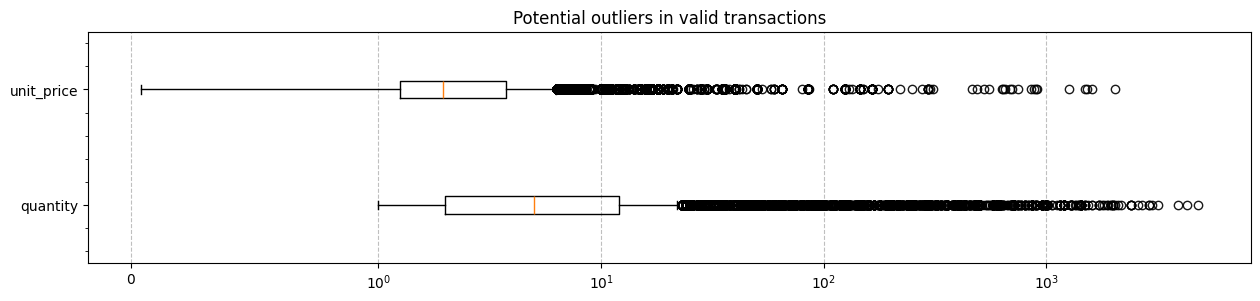

In [47]:
# Boxplots of numeric columns
fig, ax = plt.subplots(figsize=(15, 3))

flierprops = dict(
    marker='o',
    markersize=6,
    linestyle='none',
    alpha=0.9
)

ax.boxplot(
    df_valids[['quantity', 'unit_price']],
    vert=False,
    whis=1.0,              # tighter whiskers → more visible outliers
    flierprops=flierprops
)

ax.set_yticklabels(['quantity', 'unit_price'])

# Grid styling
ax.grid(False, axis='y')
ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.8)
ax.grid(True, axis='x', which='minor', linestyle='--', alpha=0.3)
ax.minorticks_on()

# Log scale to handle skew (safe for retail data)
ax.set_xscale('symlog', linthresh=1)

ax.set_title("Potential outliers in valid transactions")
ax.set_ylabel("")
ax.set_xlabel("")

print('Notice potential outliers in valid transactions...')
plt.show()


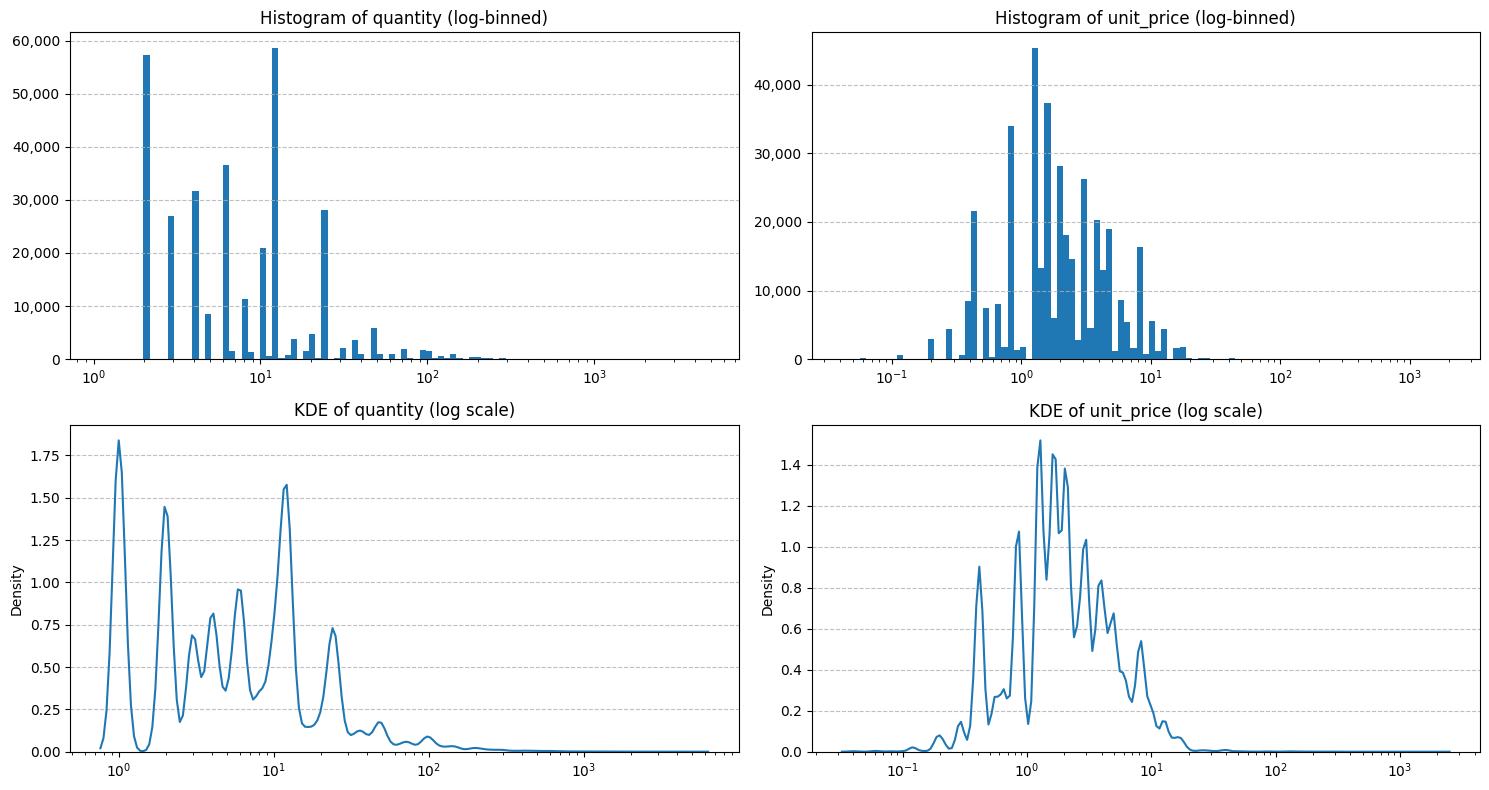

In [48]:
# Histograms and KDEs
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Log-spaced bins
quantity_bins = np.logspace(np.log10(df_valids['quantity'].min()+1e-1), 
                            np.log10(df_valids['quantity'].max()+1), 100)
unit_price_bins = np.logspace(np.log10(df_valids['unit_price'].min()+1e-3), 
                              np.log10(df_valids['unit_price'].max()+1), 100)

# --- Histograms ---
# quantity histogram
axes[0, 0].hist(df_valids['quantity'], bins=quantity_bins)
axes[0, 0].set_xscale('log')
axes[0, 0].set_title('Histogram of quantity (log-binned)')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('')
axes[0, 0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
axes[0, 0].grid(True, axis='y', which='major', linestyle='--', alpha=0.8)


# unit_price histogram
axes[0, 1].hist(df_valids['unit_price'], bins=unit_price_bins)
axes[0, 1].set_xscale('log')
axes[0, 1].set_title('Histogram of unit_price (log-binned)')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
axes[0, 1].grid(True, axis='y', which='major', linestyle='--', alpha=0.8)

# --- KDE plots ---
# quantity KDE
sns.kdeplot(df_valids['quantity'], ax=axes[1, 0], log_scale=True)
axes[1, 0].set_title('KDE of quantity (log scale)')
axes[1, 0].set_xlabel('')
axes[1, 0].grid(True, axis='y', which='major', linestyle='--', alpha=0.8)

# unit_price KDE
sns.kdeplot(df_valids['unit_price'], ax=axes[1, 1], log_scale=True)
axes[1, 1].set_title('KDE of unit_price (log scale)')
axes[1, 1].set_xlabel('')
axes[1, 1].grid(True, axis='y', which='major', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

In [49]:
num_cols = ['quantity', 'unit_price']

# Calculate IQR and bounds
Q1 = df_valids[num_cols].quantile(0.25)
Q3 = df_valids[num_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers per column
outlier_counts = {
    col: ((df_valids[col] < lower_bound[col]) | 
          (df_valids[col] > upper_bound[col])).sum()
    for col in num_cols
}

# Summary table with outlier counts
netting_iqr_summary = pd.DataFrame({
    'Q1': Q1,
    'Q3': Q3,
    'IQR': IQR,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound,
    'Potential Outlier Transactions': pd.Series(outlier_counts)
})

netting_iqr_summary.applymap(
    lambda x: f"{x:,}" if pd.notnull(x) else x
)

,Q1,Q3,IQR,Lower Bound,Upper Bound,Potential Outlier Transactions
quantity,2.0,12.0,10.0,-13.0,27.0,"24,885"
unit_price,1.25,3.75,2.5,-2.5,7.5,"33,058"


In [50]:
netting_outliers_df = df_valids[
    (df_valids['quantity'] < lower_bound['quantity']) |
    (df_valids['quantity'] > upper_bound['quantity']) |
    (df_valids['unit_price'] < lower_bound['unit_price']) |
    (df_valids['unit_price'] > upper_bound['unit_price'])
]

netting_outliers_df

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,_orig_index
1,556201,17021,NAMASTE SWAGAT INCENSE,36,2011-06-09 13:01:00,0.30,12347.0,Iceland,220583
66,542237,22423,REGENCY CAKESTAND 3 TIER,3,2011-01-26 14:30:00,12.75,12347.0,Iceland,72267
67,549222,22423,REGENCY CAKESTAND 3 TIER,3,2011-04-07 10:43:00,12.75,12347.0,Iceland,148300
68,562032,22423,REGENCY CAKESTAND 3 TIER,3,2011-08-02 08:48:00,12.75,12347.0,Iceland,286637
69,573511,22423,REGENCY CAKESTAND 3 TIER,6,2011-10-31 12:25:00,12.75,12347.0,Iceland,428966
...,...,...,...,...,...,...,...,...,...
392140,554065,85039A,SET/4 RED MINI ROSE CANDLE IN BOWL,48,2011-05-22 10:39:00,1.45,18287.0,United Kingdom,198739
392141,570715,85039A,SET/4 RED MINI ROSE CANDLE IN BOWL,48,2011-10-12 10:23:00,1.45,18287.0,United Kingdom,392745
392142,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,60,2011-05-22 10:39:00,1.45,18287.0,United Kingdom,198741
392144,570715,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,48,2011-10-12 10:23:00,1.45,18287.0,United Kingdom,392744


#### [CHOSEN] Route B (Cont.) 

In [51]:
# Re-Check Data
details = str_py(df_valids_)
styled_details = (
    details.sort_values(by='missing ratio', ascending=False)
    .style
    .format({
        'counts': '{:,.0f}',
        'distincts': '{:,.0f}',
        'nulls': '{:,.0f}',
        'missing ratio': '{:.2f}%'
    })
    .set_properties(subset=['uniques'], **{'text-align': 'left'})
)
styled_details

Data Shape: (397880, 8)
Data Types: 
types
object            4
float64           2
datetime64[ns]    1
int64             1
Name: count, dtype: int64


Notice potential outliers in valid transactions...


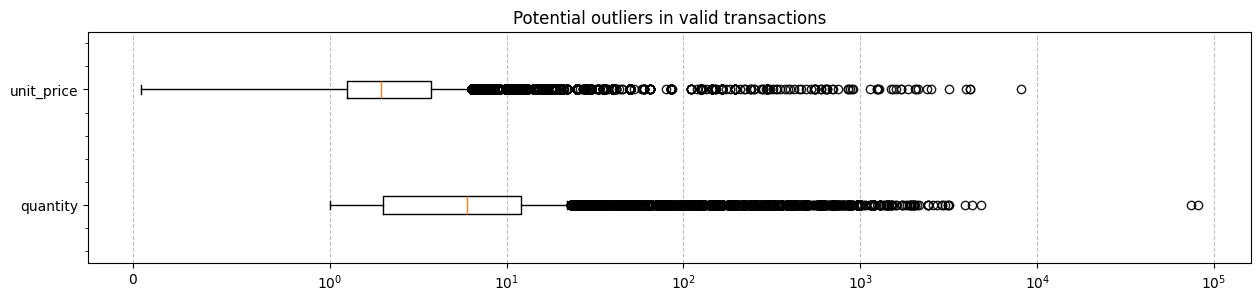

In [52]:
# Boxplots of numeric columns
fig, ax = plt.subplots(figsize=(15, 3))

flierprops = dict(
    marker='o',
    markersize=6,
    linestyle='none',
    alpha=0.9
)

ax.boxplot(
    df_valids_[['quantity', 'unit_price']],
    vert=False,
    whis=1.0,              # tighter whiskers → more visible outliers
    flierprops=flierprops
)

ax.set_yticklabels(['quantity', 'unit_price'])

# Grid styling
ax.grid(False, axis='y')
ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.8)
ax.grid(True, axis='x', which='minor', linestyle='--', alpha=0.3)
ax.minorticks_on()

# Log scale to handle skew (safe for retail data)
ax.set_xscale('symlog', linthresh=1)

ax.set_title("Potential outliers in valid transactions")
ax.set_ylabel("")
ax.set_xlabel("")

print('Notice potential outliers in valid transactions...')
plt.show()


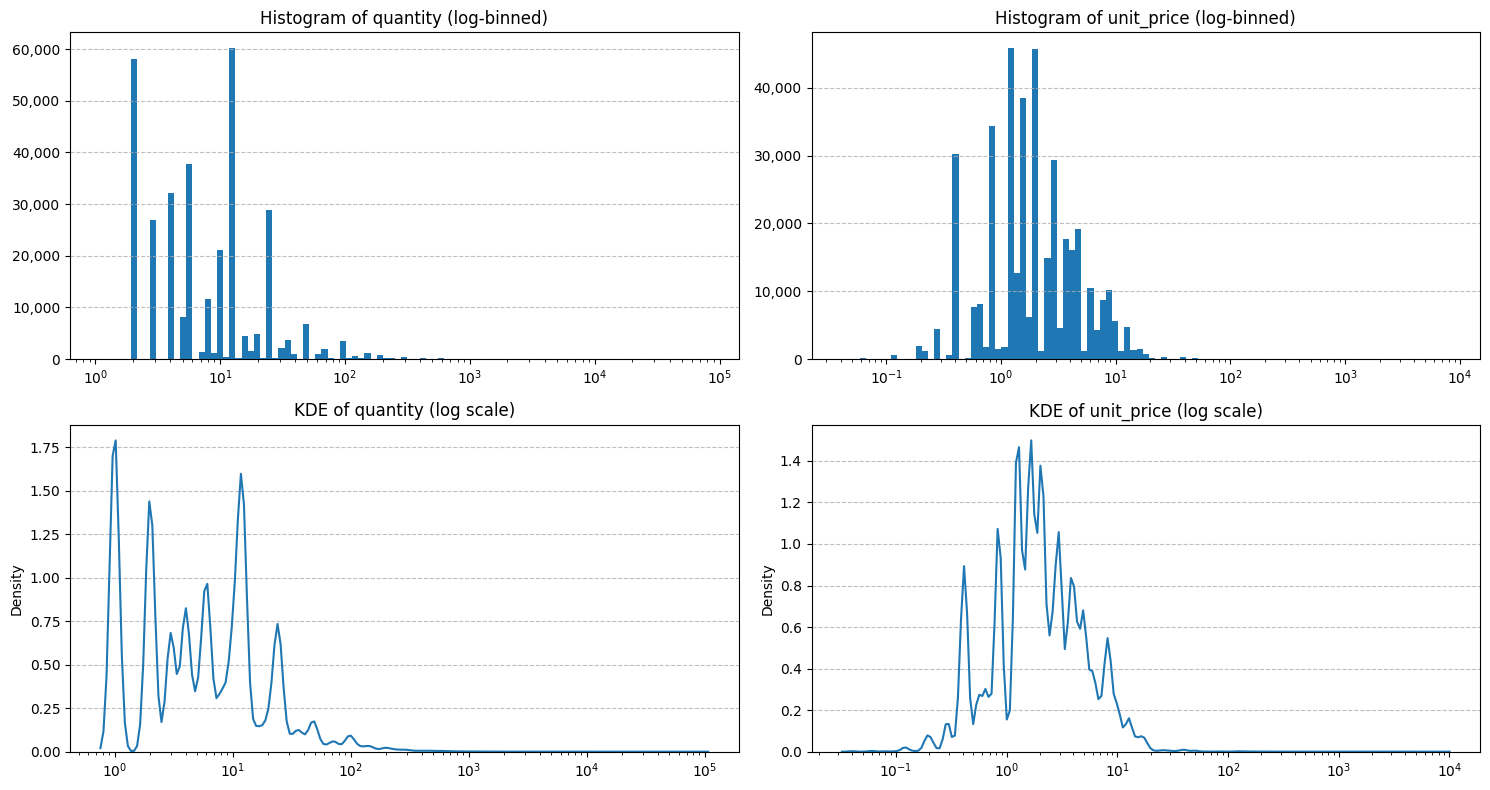

In [53]:
# Histograms and KDEs
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Log-spaced bins
quantity_bins = np.logspace(np.log10(df_valids_['quantity'].min()+1e-1), 
                            np.log10(df_valids_['quantity'].max()+1), 100)
unit_price_bins = np.logspace(np.log10(df_valids_['unit_price'].min()+1e-3), 
                              np.log10(df_valids_['unit_price'].max()+1), 100)

# --- Histograms ---
# quantity histogram
axes[0, 0].hist(df_valids_['quantity'], bins=quantity_bins)
axes[0, 0].set_xscale('log')
axes[0, 0].set_title('Histogram of quantity (log-binned)')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('')
axes[0, 0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
axes[0, 0].grid(True, axis='y', which='major', linestyle='--', alpha=0.8)


# unit_price histogram
axes[0, 1].hist(df_valids_['unit_price'], bins=unit_price_bins)
axes[0, 1].set_xscale('log')
axes[0, 1].set_title('Histogram of unit_price (log-binned)')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
axes[0, 1].grid(True, axis='y', which='major', linestyle='--', alpha=0.8)

# --- KDE plots ---
# quantity KDE
sns.kdeplot(df_valids_['quantity'], ax=axes[1, 0], log_scale=True)
axes[1, 0].set_title('KDE of quantity (log scale)')
axes[1, 0].set_xlabel('')
axes[1, 0].grid(True, axis='y', which='major', linestyle='--', alpha=0.8)

# unit_price KDE
sns.kdeplot(df_valids_['unit_price'], ax=axes[1, 1], log_scale=True)
axes[1, 1].set_title('KDE of unit_price (log scale)')
axes[1, 1].set_xlabel('')
axes[1, 1].grid(True, axis='y', which='major', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

In [54]:
num_cols = ['quantity', 'unit_price']

# Calculate IQR and bounds
Q1 = df_valids_[num_cols].quantile(0.25)
Q3 = df_valids_[num_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers per column
outlier_counts = {
    col: ((df_valids_[col] < lower_bound[col]) | 
          (df_valids_[col] > upper_bound[col])).sum()
    for col in num_cols
}

# Summary table with outlier counts
iqr_summary = pd.DataFrame({
    'Q1': Q1,
    'Q3': Q3,
    'IQR': IQR,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound,
    'Potential Outlier Transactions': pd.Series(outlier_counts)
})

iqr_summary.applymap(
    lambda x: f"{x:,}" if pd.notnull(x) else x
)

,Q1,Q3,IQR,Lower Bound,Upper Bound,Potential Outlier Transactions
quantity,2.0,12.0,10.0,-13.0,27.0,"25,647"
unit_price,1.25,3.75,2.5,-2.5,7.5,"34,356"


In [55]:
outliers_df = df_valids_[
    (df_valids_['quantity'] < lower_bound['quantity']) |
    (df_valids_['quantity'] > upper_bound['quantity']) |
    (df_valids_['unit_price'] < lower_bound['unit_price']) |
    (df_valids_['unit_price'] > upper_bound['unit_price'])
]

outliers_df

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
16,536367,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2010-12-01 08:34:00,9.95,13047.0,United Kingdom
19,536367,21777,RECIPE BOX WITH METAL HEART,4,2010-12-01 08:34:00,7.95,13047.0,United Kingdom
20,536367,48187,DOORMAT NEW ENGLAND,4,2010-12-01 08:34:00,7.95,13047.0,United Kingdom
...,...,...,...,...,...,...,...,...
541865,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09 12:23:00,1.45,13777.0,United Kingdom
541866,581583,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,36,2011-12-09 12:23:00,1.85,13777.0,United Kingdom
541867,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,72,2011-12-09 12:25:00,0.72,13777.0,United Kingdom
541868,581584,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,48,2011-12-09 12:25:00,1.85,13777.0,United Kingdom


## Final Checks on Data
Using Route B.

In [56]:
df_valids_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397880 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   invoice_number  397880 non-null  object        
 1   stock_code      397880 non-null  object        
 2   description     397880 non-null  object        
 3   quantity        397880 non-null  int64         
 4   invoice_date    397880 non-null  datetime64[ns]
 5   unit_price      397880 non-null  float64       
 6   customer_id     397880 non-null  float64       
 7   country         397880 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [57]:
df_valids_.describe()

,quantity,invoice_date,unit_price,customer_id
count,397880.000000,397880,397880.000000,397880.000000
mean,12.988358,2011-07-10 23:41:05.443248896,3.116519,15294.428491
min,1.000000,2010-12-01 08:26:00,0.040000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,179.332672,NaN,22.097986,1713.145555


In [58]:
# Final Check 
details = str_py(df_valids_)
styled_details = (
    details.sort_values(by='missing ratio', ascending=False)
    .style
    .format({
        'counts': '{:,.0f}',
        'distincts': '{:,.0f}',
        'nulls': '{:,.0f}',
        'missing ratio': '{:.2f}%'
    })
    .set_properties(subset=['uniques'], **{'text-align': 'left'})
)
styled_details

Data Shape: (397880, 8)
Data Types: 
types
object            4
float64           2
datetime64[ns]    1
int64             1
Name: count, dtype: int64


## Save Cleaned Data

In [ ]:
df_valids_.to_csv('../data/online_retail_cleaned.csv', sep='\t', encoding='utf-8', index=False, header=True)

In [60]:
df_valids_.to_excel('../data/online_retail_cleaned.xlsx', index=False, header=True)

---